In [1]:
import zipfile
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score



In [2]:
with zipfile.ZipFile('titanic.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_x = train.drop(['Survived'], axis=1)
train_y = train['Survived']

In [6]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [7]:
train_x['Age'] = train_x['Age'].fillna(train_x['Age'].mean())
train_x['Fare'] = train_x['Fare'].fillna(train_x['Fare'].mean())
train_x['Embarked'] = train_x['Embarked'].fillna(train_x['Embarked'].mode()[0])

In [8]:
train_x = train_x.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [9]:
# Hacer sex booleano
train_x['Sex'] = np.where(train_x['Sex'] == 'male', 1, 0)

In [10]:
train_x['Embarked'].value_counts()

,count
Embarked,
S,646
C,168
Q,77


In [11]:
train_x['Pclass'].value_counts()

,count
Pclass,
3,491
1,216
2,184


In [12]:
# Aplicar OneHotEncoder a Embarked
encoder = OneHotEncoder()
embarked_encoded = encoder.fit_transform(train_x[['Embarked', 'Pclass']])
train_x = pd.concat([
    train_x,
    pd.DataFrame(embarked_encoded.toarray(),
                 columns=encoder.get_feature_names_out(['Embarked', 'Pclass']))
], axis=1)

In [13]:
train_x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,3,1,22.000000,1,0,7.2500,S,0.0,0.0,1.0,0.0,0.0,1.0
1,1,0,38.000000,1,0,71.2833,C,1.0,0.0,0.0,1.0,0.0,0.0
2,3,0,26.000000,0,0,7.9250,S,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0,35.000000,1,0,53.1000,S,0.0,0.0,1.0,1.0,0.0,0.0
4,3,1,35.000000,0,0,8.0500,S,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000,S,0.0,0.0,1.0,0.0,1.0,0.0
887,1,0,19.000000,0,0,30.0000,S,0.0,0.0,1.0,1.0,0.0,0.0
888,3,0,29.699118,1,2,23.4500,S,0.0,0.0,1.0,0.0,0.0,1.0
889,1,1,26.000000,0,0,30.0000,C,1.0,0.0,0.0,1.0,0.0,0.0


In [14]:
train_x = train_x.drop(['Embarked', 'Pclass'], axis=1)
train_x = train_x.dropna()
train_y = train_y[train_x.index]

In [15]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sex         891 non-null    int64  
 1   Age         891 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Embarked_C  891 non-null    float64
 6   Embarked_Q  891 non-null    float64
 7   Embarked_S  891 non-null    float64
 8   Pclass_1    891 non-null    float64
 9   Pclass_2    891 non-null    float64
 10  Pclass_3    891 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 76.7 KB


In [16]:
# Reiniciar indices
train_x = train_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)

In [17]:
train_x_reduced, val_x, train_y_reduced, val_y = train_test_split(train_x.copy(), train_y.copy(), test_size=0.2, random_state=42)

In [18]:
train_x.head()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,0.0,1.0
1,0,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,0.0
2,0,26.0,0,0,7.9250,0.0,0.0,1.0,0.0,0.0,1.0
3,0,35.0,1,0,53.1000,0.0,0.0,1.0,1.0,0.0,0.0
4,1,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,0.0,1.0


# Gráficos

/tmp/ipython-input-709588124.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(train_x_reduced[train_y == 1]['Age'].dropna(), bins=20, alpha=0.6, label='Survived', edgecolor='black')
/tmp/ipython-input-709588124.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(train_x_reduced[train_y == 0]['Age'].dropna(), bins=20, alpha=0.6, label='Not Survived', edgecolor='black')


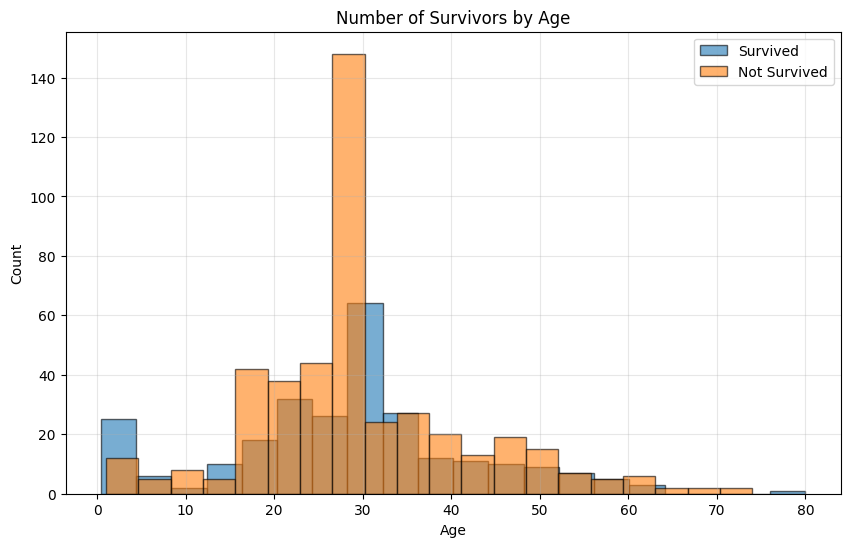

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(train_x_reduced[train_y == 1]['Age'].dropna(), bins=20, alpha=0.6, label='Survived', edgecolor='black')
plt.hist(train_x_reduced[train_y == 0]['Age'].dropna(), bins=20, alpha=0.6, label='Not Survived', edgecolor='black')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Number of Survivors by Age')
plt.grid(True, alpha=0.3)
plt.show()

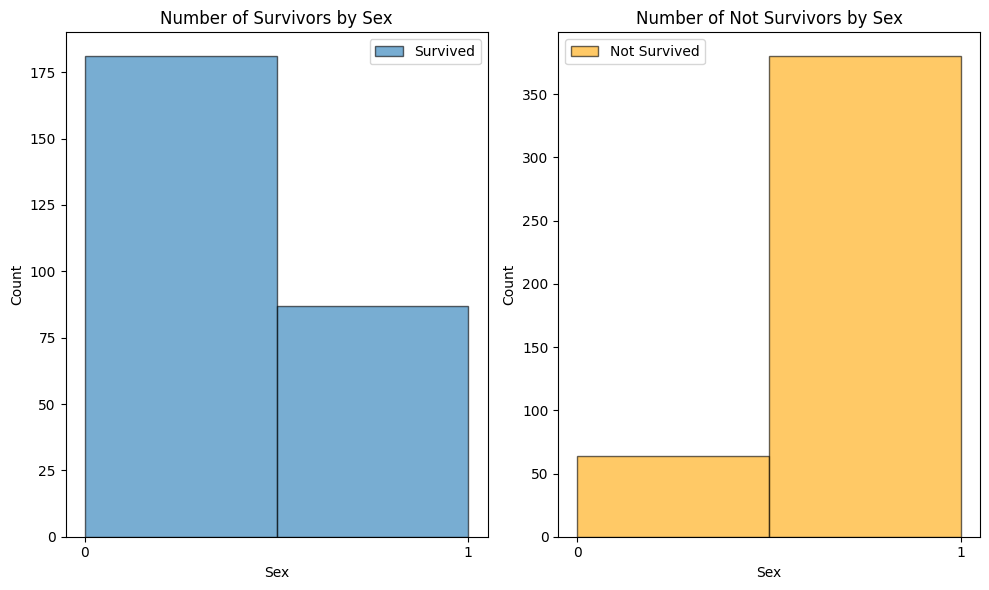

In [20]:
plt.figure(figsize=(10, 6))

survived_sex = train_x_reduced[train_y_reduced == 1]['Sex']
not_survived_sex = train_x_reduced[train_y_reduced == 0]['Sex']
plt.subplot(1, 2, 1)
plt.hist(survived_sex, bins=2, alpha=0.6, label='Survived', edgecolor='black')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Number of Survivors by Sex')
plt.xticks([0, 1])
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(not_survived_sex, bins=2, alpha=0.6, label='Not Survived', color='orange', edgecolor='black')

plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Number of Not Survivors by Sex')
plt.xticks([0, 1])
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
per_woman = train_x[train_x['Sex'] == 0].shape[0] / train_x.shape[0] * 100
print(f"Porcentaje de mujeres en el conjunto de entrenamiento: {per_woman:.2f}%")

Porcentaje de mujeres en el conjunto de entrenamiento: 35.24%


In [22]:
survived_sex_woman = train_x[(train_y == 1) & (train_x['Sex'] == 0)].shape[0] / train_x[train_y == 1].shape[0] * 100

print(f"Porcentaje de mujeres supervivientes en el conjunto de entrenamiento: {survived_sex_woman:.2f}%")

Porcentaje de mujeres supervivientes en el conjunto de entrenamiento: 68.13%


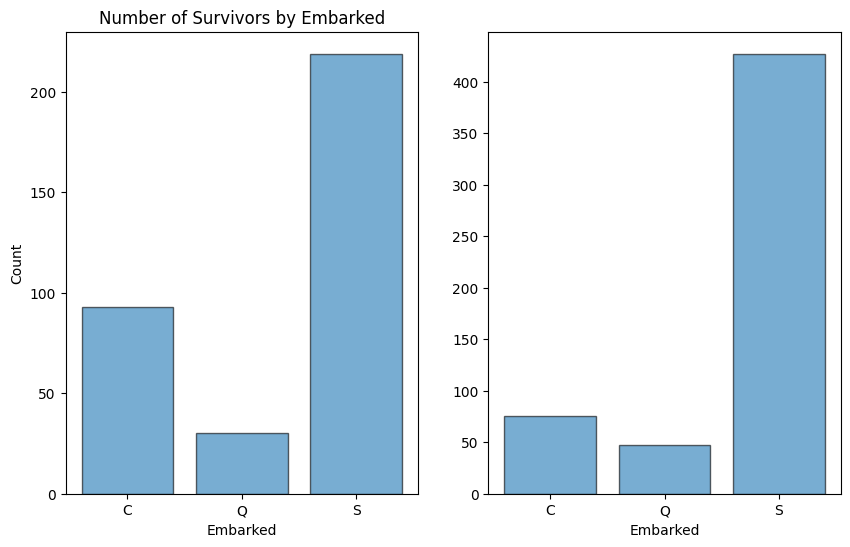

In [23]:
plt.figure(figsize=(10, 6))
embarked_counts_survived = [
    train_x[train_y == 1]['Embarked_C'].sum(),
    train_x[train_y == 1]['Embarked_Q'].sum(),
    train_x[train_y == 1]['Embarked_S'].sum()
]
embarked_counts_not_survived = [
    train_x[train_y == 0]['Embarked_C'].sum(),
    train_x[train_y == 0]['Embarked_Q'].sum(),
    train_x[train_y == 0]['Embarked_S'].sum()
]
plt.subplot(1, 2, 1)
plt.bar(['C', 'Q', 'S'], embarked_counts_survived, alpha=0.6, edgecolor='black')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.title('Number of Survivors by Embarked')

plt.subplot(1, 2, 2)
plt.bar(['C', 'Q', 'S'], embarked_counts_not_survived, alpha=0.6, edgecolor='black')
plt.xlabel('Embarked')
plt.show()

# Comparaciones de supervivientes con el total y con las categorías mismas

In [24]:
print(f"Porcentaje de representación en el conjunto de embarque S: {train_x['Embarked_S'].sum() / train_x.shape[0] * 100:.2f}%")

embarked_s_survived_total = train_x[train_y == 1]['Embarked_S'].sum() / train_x[train_y == 1].shape[0] * 100
print(f"Porcentaje de supervivientes en el conjunto de entrenamiento que embarcaron en S (total): {embarked_s_survived_total:.2f}%")

embarked_s_survived_category = train_x[train_y == 1]['Embarked_S'].sum() / train_x['Embarked_S'].shape[0] * 100
print(f"Porcentaje de supervivientes en el conjunto de entrenamiento que embarcaron en S (misma categoría):{embarked_s_survived_category:.2f}%")

Porcentaje de representación en el conjunto de embarque S: 72.50%
Porcentaje de supervivientes en el conjunto de entrenamiento que embarcaron en S (total): 64.04%
Porcentaje de supervivientes en el conjunto de entrenamiento que embarcaron en S (misma categoría):24.58%


In [25]:
print(f"Porcentaje de representación en el conjunto de embarque Q: {train_x['Embarked_Q'].sum() / train_x.shape[0] * 100:.2f}%")

embarked_q_survived_total = train_x[train_y == 1]['Embarked_Q'].sum() / train_x[train_y == 1].shape[0] * 100
print(f"Porcentaje de supervivientes en el conjunto de entrenamiento que embarcaron en Q (total): {embarked_q_survived_total:.2f}%")

embarked_q_survived_category = train_x[train_y == 1]['Embarked_Q'].sum() / train_x['Embarked_Q'].shape[0] * 100
print(f"Porcentaje de supervivientes en el conjunto de entrenamiento que embarcaron en Q (misma categoría):{embarked_q_survived_category:.2f}%")

Porcentaje de representación en el conjunto de embarque Q: 8.64%
Porcentaje de supervivientes en el conjunto de entrenamiento que embarcaron en Q (total): 8.77%
Porcentaje de supervivientes en el conjunto de entrenamiento que embarcaron en Q (misma categoría):3.37%


In [26]:
print(f"Porcentaje de representación en el conjunto de embarque C: {train_x['Embarked_C'].sum() / train_x.shape[0] * 100:.2f}%")

embarked_c_survived_total = train_x[train_y == 1]['Embarked_C'].sum() / train_x[train_y == 1].shape[0] * 100
print(f"Porcentaje de supervivientes en el conjunto de entrenamiento que embarcaron en C (total): {embarked_c_survived_total:.2f}%")

embarked_c_survived_category = train_x[train_y == 1]['Embarked_C'].sum() / train_x['Embarked_C'].shape[0] * 100
print(f"Porcentaje de supervivientes en el conjunto de entrenamiento que embarcaron en C (misma categoría):{embarked_c_survived_category:.2f}%")

Porcentaje de representación en el conjunto de embarque C: 18.86%
Porcentaje de supervivientes en el conjunto de entrenamiento que embarcaron en C (total): 27.19%
Porcentaje de supervivientes en el conjunto de entrenamiento que embarcaron en C (misma categoría):10.44%


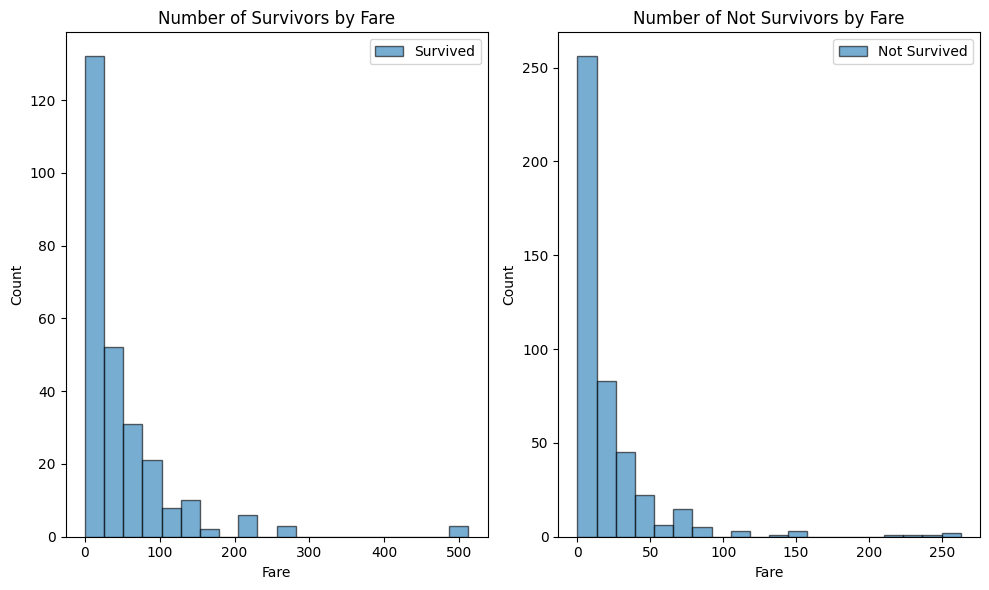

In [27]:
plt.figure(figsize=(10, 6))
# Fare | survived
plt.subplot(1, 2, 1)
plt.hist(train_x_reduced[train_y_reduced == 1]['Fare'].dropna(), bins=20, alpha=0.6, label='Survived', edgecolor='black')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Number of Survivors by Fare')
plt.legend()

plt.subplot(1, 2, 2)
# Fare | not survived
plt.hist(train_x_reduced[train_y_reduced == 0]['Fare'].dropna(), bins=20, alpha=0.6, label='Not Survived', edgecolor='black')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Number of Not Survivors by Fare')
plt.legend()
plt.tight_layout()
plt.show()

# Supervivientes por Clase
La Primera clase tiene una gran superioridad en comparación al resto en cuanto a ratio de supervivencia ya que, siendo casi el mismo porcentaje sobre el total de pasajeros del Titanic que en segunda clase; y siendo menos de la mitad que los de tercera clase; son los que tienen mayor representación con diferencia entre los supervivientes.

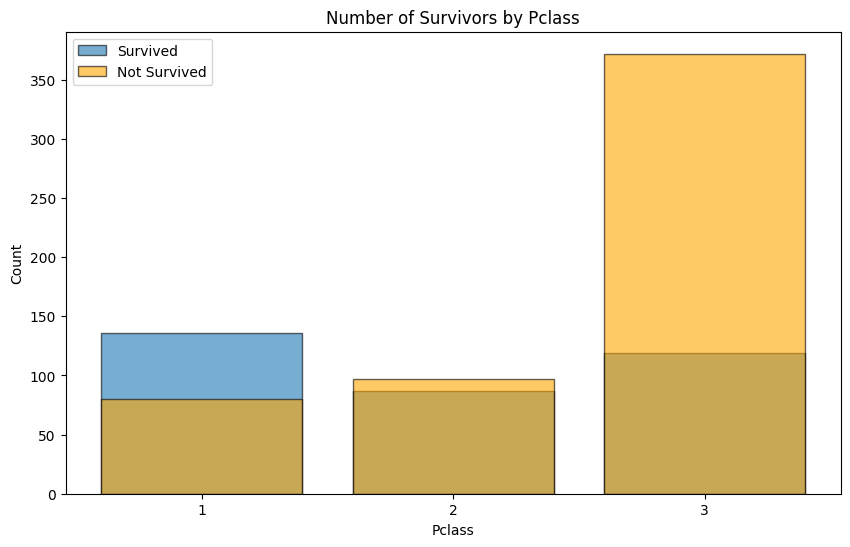

In [28]:
p1_class_survived = train_x[train_y == 1]['Pclass_1'].sum()
p2_class_survived = train_x[train_y == 1]['Pclass_2'].sum()
p3_class_survived = train_x[train_y == 1]['Pclass_3'].sum()

p1_class_not_survived = train_x[train_y == 0]['Pclass_1'].sum()
p2_class_not_survived = train_x[train_y == 0]['Pclass_2'].sum()
p3_class_not_survived = train_x[train_y == 0]['Pclass_3'].sum()

plt.figure(figsize=(10, 6))
plt.bar(['1', '2', '3'], [p1_class_survived, p2_class_survived, p3_class_survived], alpha=0.6, label='Survived', edgecolor='black')
plt.bar(['1', '2', '3'], [p1_class_not_survived, p2_class_not_survived, p3_class_not_survived], alpha=0.6, label='Not Survived', color='orange', edgecolor='black')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.title('Number of Survivors by Pclass')
plt.legend()
plt.show()

In [29]:
print(f"Porcentaje de representación de primera clase sobre el total: {train_x[train_x['Pclass_1'] == 1].shape[0] / train_x.shape[0] * 100:.2f}%")

class_1_survived_total = train_x[train_y == 1]['Pclass_1'].sum() / train_x[train_y == 1].shape[0] * 100
print(f"Porcentaje de supervivientes en el conjunto de entrenamiento que viajaban en la clase 1 (total): {class_1_survived_total:.2f}%")

class_1_survived_category = train_x[train_y == 1]['Pclass_1'].sum() / train_x['Pclass_1'].shape[0] * 100
print(f"Porcentaje de supervivientes en el conjunto de entrenamiento que viajaban en la clase 1 (misma categoría): {class_1_survived_category:.2f}%")

Porcentaje de representación de primera clase sobre el total: 24.24%
Porcentaje de supervivientes en el conjunto de entrenamiento que viajaban en la clase 1 (total): 39.77%
Porcentaje de supervivientes en el conjunto de entrenamiento que viajaban en la clase 1 (misma categoría): 15.26%


In [30]:
print(f"Porcentaje de representación de segunda clase sobre el total: {train_x[train_x['Pclass_2'] == 1].shape[0] / train_x.shape[0] * 100:.2f}%")

class_2_survived_total = train_x[train_y == 1]['Pclass_2'].sum() / train_x[train_y == 1].shape[0] * 100
print(f"Porcentaje de supervivientes en el conjunto de entrenamiento que viajaban en la clase 2 (total): {class_2_survived_total:.2f}%")

class_2_survived_category = train_x[train_y == 1]['Pclass_2'].sum() / train_x['Pclass_2'].shape[0] * 100
print(f"Porcentaje de supervivientes en el conjunto de entrenamiento que viajaban en la clase 2 (misma categoría): {class_2_survived_category:.2f}%")

Porcentaje de representación de segunda clase sobre el total: 20.65%
Porcentaje de supervivientes en el conjunto de entrenamiento que viajaban en la clase 2 (total): 25.44%
Porcentaje de supervivientes en el conjunto de entrenamiento que viajaban en la clase 2 (misma categoría): 9.76%


In [31]:
print(f"Porcentaje de representación de tercera clase sobre el total: {train_x[train_x['Pclass_3'] == 1].shape[0] / train_x.shape[0] * 100:.2f}%")

class_3_survived_total = train_x[train_y == 1]['Pclass_3'].sum() / train_x[train_y == 1].shape[0] * 100
print(f"Porcentaje de supervivientes en el conjunto de entrenamiento que viajaban en la clase 1 (total): {class_3_survived_total:.2f}%")

class_3_survived_category = train_x[train_y == 1]['Pclass_3'].sum() / train_x['Pclass_3'].shape[0] * 100
print(f"Porcentaje de supervivientes en el conjunto de entrenamiento que viajaban en la clase 1 (misma categoría): {class_3_survived_category:.2f}%")

Porcentaje de representación de tercera clase sobre el total: 55.11%
Porcentaje de supervivientes en el conjunto de entrenamiento que viajaban en la clase 1 (total): 34.80%
Porcentaje de supervivientes en el conjunto de entrenamiento que viajaban en la clase 1 (misma categoría): 13.36%


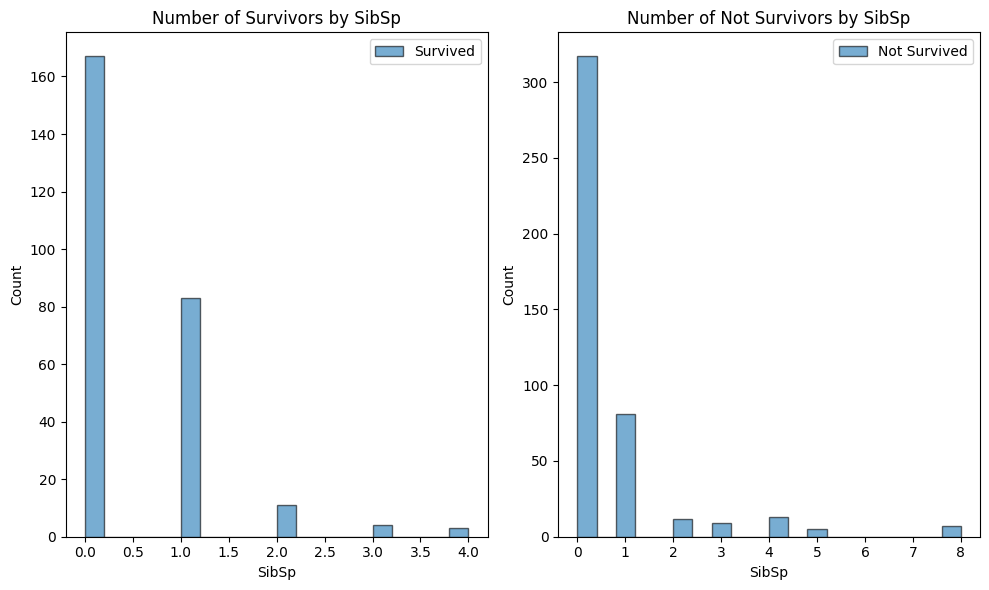

In [32]:
# sib | survived
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(train_x_reduced[train_y_reduced == 1]['SibSp'].dropna(), bins=20, alpha=0.6, label='Survived', edgecolor='black')
plt.xlabel('SibSp')
plt.ylabel('Count')
plt.title('Number of Survivors by SibSp')
plt.legend()

plt.subplot(1, 2, 2)
# sib | not survived
plt.hist(train_x_reduced[train_y_reduced == 0]['SibSp'].dropna(), bins=20, alpha=0.6, label='Not Survived', edgecolor='black')
plt.xlabel('SibSp')
plt.ylabel('Count')
plt.title('Number of Not Survivors by SibSp')
plt.legend()
plt.tight_layout()
plt.show()

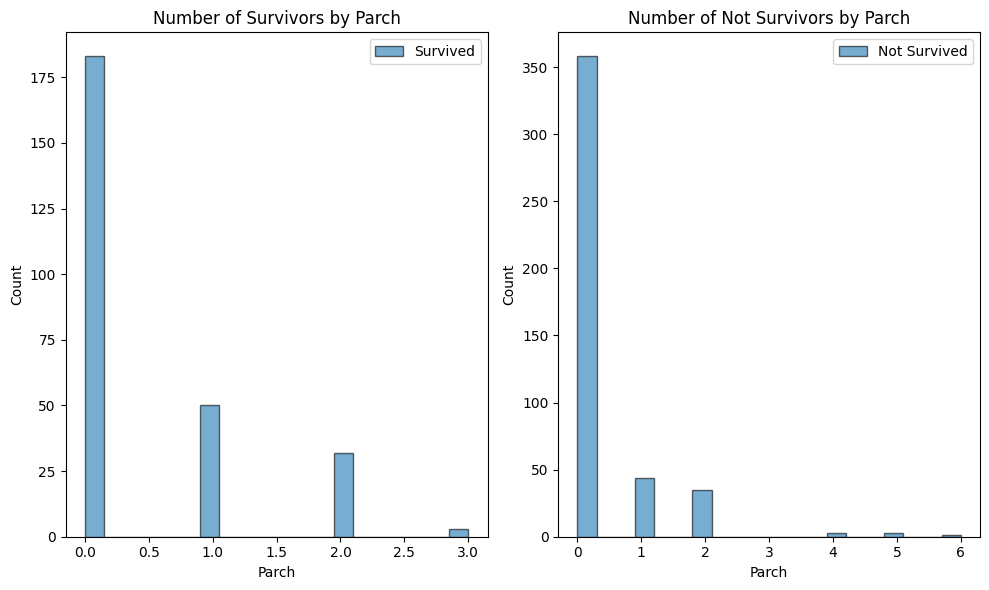

In [33]:
# Parch | survived
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(train_x_reduced[train_y_reduced == 1]['Parch'].dropna(), bins=20, alpha=0.6, label='Survived', edgecolor='black')
plt.xlabel('Parch')
plt.ylabel('Count')
plt.title('Number of Survivors by Parch')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(train_x_reduced[train_y_reduced == 0]['Parch'].dropna(), bins=20, alpha=0.6, label='Not Survived', edgecolor='black')
plt.xlabel('Parch')
plt.ylabel('Count')
plt.title('Number of Not Survivors by Parch')
plt.legend()
plt.tight_layout()
plt.show()

# ¿Qué características son las más importantes para predecir la supervivencia?
### Las carácteríasticas más importantes son 'Sex', 'Class' y 'Age'
Claramente las mujeres de primera clase entre la edad de 16 y 40 años representan la mayoría de los supervivientes.

In [34]:
# Function to get the original Embarked value from one-hot encoded columns


def get_pclass(row):
    if row['Pclass_1'] == 1.0:
        return 1
    elif row['Pclass_2'] == 1.0:
        return 2
    elif row['Pclass_3'] == 1.0:
        return 3
    return None

In [35]:
def join_data(data):
  data['Pclass'] = data.apply(get_pclass, axis=1)

  # Mapear Sex a etiquetas legibles
  data['Sex_label'] = data['Sex'].map({0: 'Female', 1: 'Male'})

  # Agrupar por Age bins, Sex, Embarked Y Pclass
  data['Age_bin'] = pd.cut(data['Age'], bins=10)
  grouped = data.groupby(['Age_bin', 'Sex_label', 'Pclass']).size().reset_index(name='Count')
  return grouped

/tmp/ipython-input-2402720805.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(['Age_bin', 'Sex_label', 'Pclass']).size().reset_index(name='Count')
/tmp/ipython-input-816108980.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = not_survived_data.pivot_table(values='Count', index='Age_bin', columns=['Sex_label', 'Pclass'], fill_value=0)


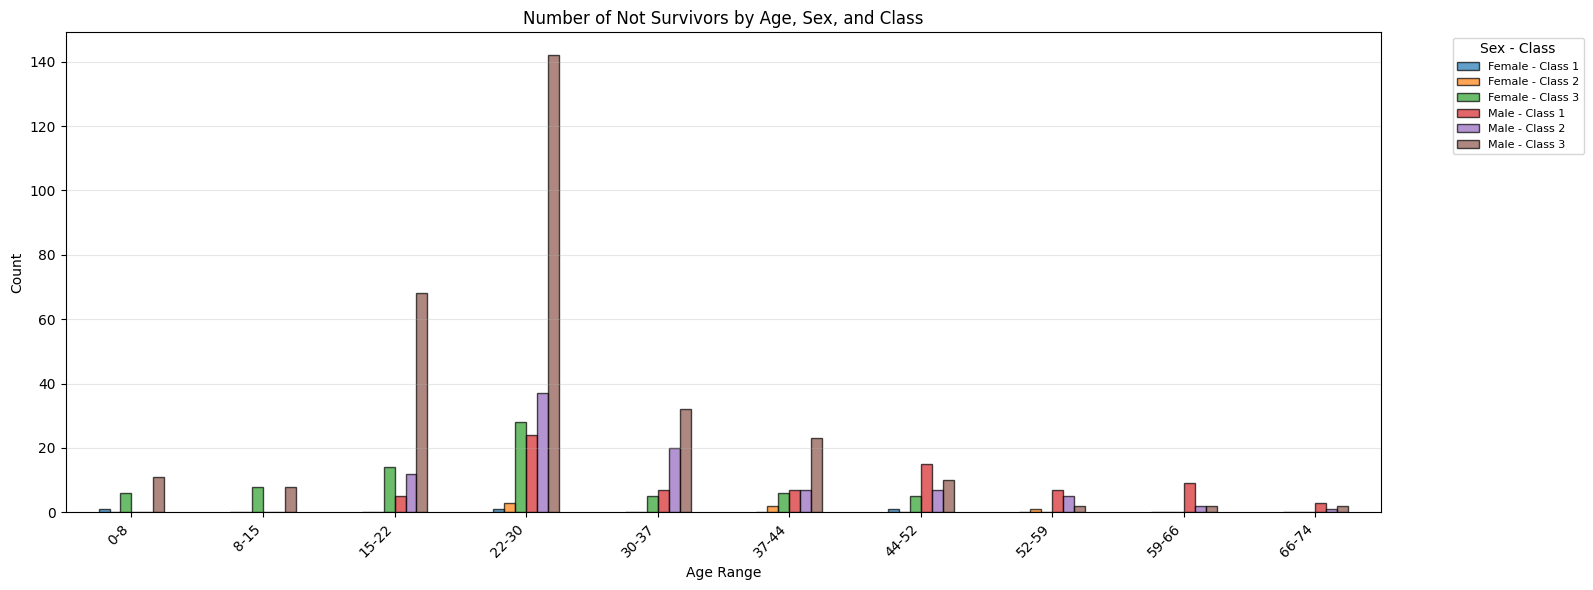

In [36]:
# Crear combinaciones de Sex y Class por rangos de edad (No Supervivientes)
not_survived_data = train_x[train_y == 0].copy()

not_survived_data = join_data(not_survived_data)

# Pivot para visualizar (ahora con Pclass)
pivot = not_survived_data.pivot_table(values='Count', index='Age_bin', columns=['Sex_label', 'Pclass'], fill_value=0)

# Crear labels personalizadas para la leyenda
pivot.columns = [f'{sex} - Class {pclass}' for sex, pclass in pivot.columns]

ax = pivot.plot(kind='bar', figsize=(16, 6), edgecolor='black', alpha=0.7)
labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in pivot.index]
ax.set_xticklabels(labels, rotation=45, ha='right')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.title('Number of Not Survivors by Age, Sex, and Class')
plt.legend(title='Sex - Class', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

/tmp/ipython-input-2402720805.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(['Age_bin', 'Sex_label', 'Pclass']).size().reset_index(name='Count')
/tmp/ipython-input-1783617941.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = survived_data.pivot_table(values='Count', index='Age_bin', columns=['Sex_label', 'Pclass'], fill_value=0)


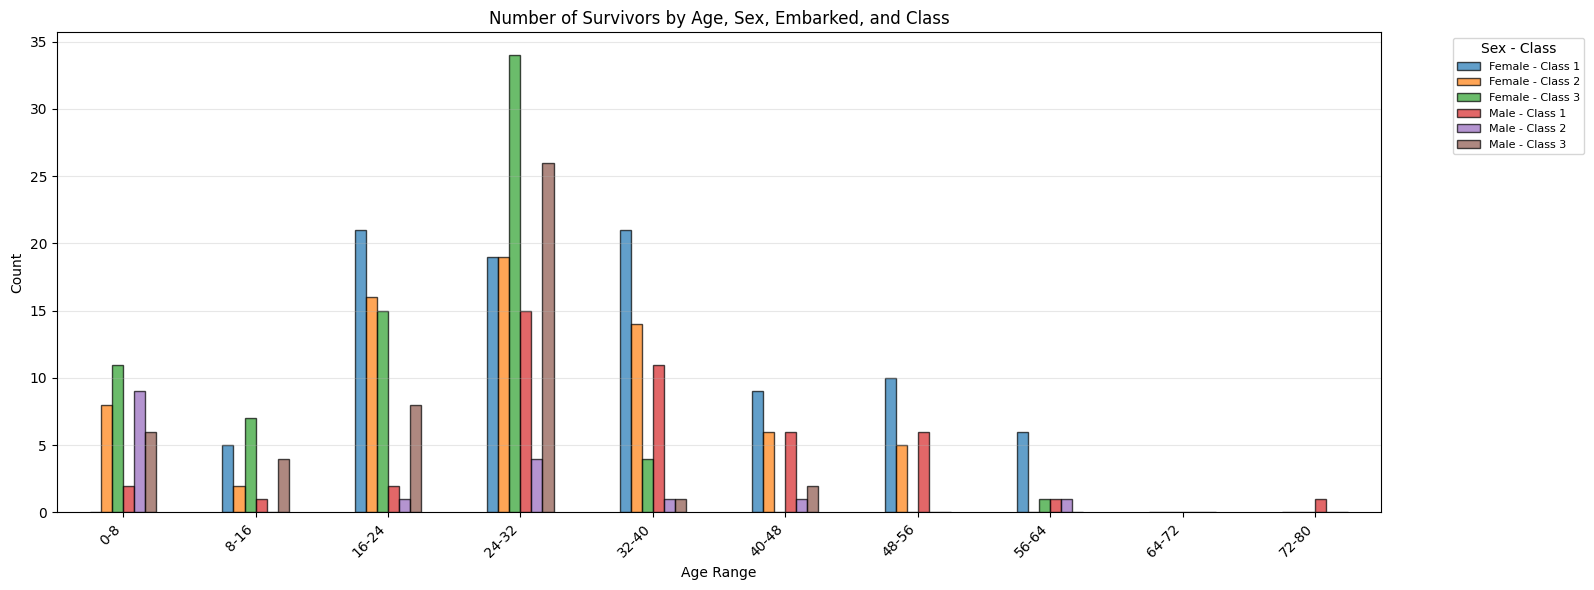

In [37]:
# Crear combinaciones de Sex y Class por rangos de edad (Supervivientes)
survived_data = train_x[train_y == 1].copy()

survived_data = join_data(survived_data)

# Pivot para visualizar (ahora con Pclass)
pivot = survived_data.pivot_table(values='Count', index='Age_bin', columns=['Sex_label', 'Pclass'], fill_value=0)

# Crear labels personalizadas para la leyenda
pivot.columns = [f'{sex} - Class {pclass}' for sex, pclass in pivot.columns]

ax = pivot.plot(kind='bar', figsize=(16, 6), edgecolor='black', alpha=0.7)
labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in pivot.index]
ax.set_xticklabels(labels, rotation=45, ha='right')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.title('Number of Survivors by Age, Sex, Embarked, and Class')
plt.legend(title='Sex - Class', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [38]:
first_woman_class = train_x[(train_x['Sex'] == 0) & (train_x['Pclass_1'] == 1)].shape[0] / train_x.shape[0] * 100
print(f"Porcentaje de mujeres de primera clase sobre el total: {first_woman_class:.2f}%")

survived_first_class_women = train_x[(train_y == 1) & (train_x['Sex'] == 0) & (train_x['Pclass_1'] == 1)].shape[0] / train_x.shape[0] * 100
print(f"Porcentaje de mujeres de primera clase que sobrevivieron sobre el total: {survived_first_class_women:.2f}%")

survived_first_class_women_category = train_x[(train_y == 1) & (train_x['Sex'] == 0) & (train_x['Pclass_1'] == 1)].shape[0] / train_x[train_y == 1].shape[0] * 100
print(f"Porcentaje de mujeres de primera clase que sobrevivieron sobre el total de supervivientes: {survived_first_class_women_category:.2f}%")

Porcentaje de mujeres de primera clase sobre el total: 10.55%
Porcentaje de mujeres de primera clase que sobrevivieron sobre el total: 10.21%
Porcentaje de mujeres de primera clase que sobrevivieron sobre el total de supervivientes: 26.61%


# Categoría compleja con más porcentaje de supervivencia : Mujeres de primera clase

In [39]:
survived_first_class_women = train_x[(train_y == 1) & (train_x['Sex'] == 0) & (train_x['Pclass_1'] == 1)].shape[0] / train_x[(train_x['Sex'] == 0) & (train_x['Pclass_1'] == 1)].shape[0] * 100
print(f"Porcentaje de mujeres de primera clase que sobrevivieron sobre el total de mujeres de primera clase: {survived_first_class_women:.2f}%")

Porcentaje de mujeres de primera clase que sobrevivieron sobre el total de mujeres de primera clase: 96.81%


In [40]:
kids_porcentaje = train_x[train_x['Age'] < 16].shape[0] / train_x.shape[0] * 100
print(f"Porcentaje de niños sobre el total: {kids_porcentaje:.2f}%")

kids_survived = train_x[(train_y == 1) & (train_x['Age'] < 16)].shape[0] / train_x[train_x['Age'] < 16].shape[0] * 100
print(f"Porcentaje de niños que sobrevivieron sobre el total: {kids_survived:.2f}%")

Porcentaje de niños sobre el total: 9.32%
Porcentaje de niños que sobrevivieron sobre el total: 59.04%


In [41]:
clf_lr = Pipeline([
    ("scaler", RobustScaler()),
    ("logistic", LogisticRegression(
        penalty='l2',
        C=0.01,
        solver='liblinear',
        max_iter=100000,
        class_weight='balanced',
        random_state=42,

    ))
])

clf_lr.fit(train_x_reduced, train_y_reduced)

Pipeline(steps=[('scaler', RobustScaler()),
                ('logistic',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=100000, random_state=42,
                                    solver='liblinear'))])

In [42]:
prediction = clf_lr.predict(val_x)
f1_score(val_y, prediction)

0.7810650887573964

In [43]:

clf = Pipeline([
    ("scaler", RobustScaler()),
    ("svm", SVC(
        kernel="poly",
        degree=3,
        coef0=5,
        C=150,
        gamma=0.03,
        class_weight='balanced',
        cache_size=1000,
        random_state=42,
        tol=1e-5
    ))
])

clf.fit(train_x_reduced, train_y_reduced)


Pipeline(steps=[('scaler', RobustScaler()),
                ('svm',
                 SVC(C=150, cache_size=1000, class_weight='balanced', coef0=5,
                     gamma=0.03, kernel='poly', random_state=42, tol=1e-05))])

In [44]:
prediction = clf.predict(val_x)

In [45]:
# F1 score
from sklearn.metrics import f1_score
f1_score(val_y, prediction)

0.7866666666666666

In [46]:
# Guardar PassengerId para el submission
passenger_ids = test['PassengerId'].copy()

# Eliminar columnas irrelevantes
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Rellenar valores faltantes ANTES de dropna
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())
test['Embarked'] = test['Embarked'].fillna(test['Embarked'].mode()[0])

# Codificar sexo
test['Sex'] = np.where(test['Sex'] == 'male', 1, 0)

# Codificar Embarked y Pclass
embarked_encoded = encoder.transform(test[['Embarked', 'Pclass']])
test = pd.concat([
    test,
    pd.DataFrame(embarked_encoded.toarray(),
                 columns=encoder.get_feature_names_out(['Embarked', 'Pclass']))
], axis=1)

# Eliminar columnas originales ya codificadas
test = test.drop(['Embarked', 'Pclass'], axis=1)

# Verificar que no quedan NaN
print(f"Valores faltantes: {test.isna().sum().sum()}")
print(f"Filas en test: {len(test)}")

Valores faltantes: 0
Filas en test: 418


In [47]:
clf_lr.fit(train_x, train_y)

Pipeline(steps=[('scaler', RobustScaler()),
                ('logistic',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=100000, random_state=42,
                                    solver='liblinear'))])

In [48]:
prediction = clf_lr.predict(test)

In [49]:
df = pd.DataFrame(prediction, columns=['Survived'])
df['PassengerId'] = passenger_ids
df = df[['PassengerId', 'Survived']]  # Reordenar columnas
df.shape

(418, 2)

In [50]:
df.to_csv('prediction_linear.csv', index=False)

In [51]:
# Entrenamiento completo
clf.fit(train_x, train_y)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm',
                 SVC(C=150, cache_size=1000, class_weight='balanced', coef0=5,
                     gamma=0.03, kernel='poly', random_state=42, tol=1e-05))])

In [52]:
prediction = clf.predict(test)

In [53]:
df = pd.DataFrame(prediction, columns=['Survived'])
df['PassengerId'] = passenger_ids
df = df[['PassengerId', 'Survived']]  # Reordenar columnas
df.shape

(418, 2)

In [54]:
df.to_csv('prediction.csv', index=False)

# Predicción del número de supervivientes en el dataset de test

In [55]:
# Calculate the number of survivors and the total number of passengers
num_survived_train = train[train['Survived'] == 1]['Survived'].sum()
total_passengers_train = train.shape[0]

# Calculate the percentage of survivors
percentage_survived_train = (num_survived_train / total_passengers_train) * 100

print(f"Percentage of survivors in the training data: {percentage_survived_train:.2f}%")

Percentage of survivors in the training data: 38.38%


In [56]:
# Calculate the number of survivors and the total number of passengers
num_survived_test = df[df['Survived'] == 1]['Survived'].sum()
total_passengers_test = df.shape[0]

# Calculate the percentage of survivors
percentage_survived_test = (num_survived_test / total_passengers_test) * 100

print(f"Percentage of survivors in the test data: {percentage_survived_test:.2f}%")

Percentage of survivors in the test data: 41.39%


In [57]:
from sklearn.model_selection import cross_val_score
import numpy as np

models = {
    'Linear': Pipeline([
        ("scaler", RobustScaler()),
        ("svm", SVC(kernel="linear", C=1.0, class_weight='balanced', random_state=42))
    ]),
    'RBF': Pipeline([
        ("scaler", RobustScaler()),
        ("svm", SVC(kernel="rbf", C=10, gamma='scale', class_weight='balanced', random_state=42))
    ]),
    'Poly': Pipeline([
        ("scaler", RobustScaler()),
        ("svm", SVC(kernel="poly", degree=3, C=150, coef0=5, gamma=0.03,
                    class_weight='balanced', random_state=42))
    ])
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, val_x, val_y, cv=5, scoring='accuracy')
    results[name] = scores
    print(f"\n{name} Kernel:")
    print(f"  CV Scores: {scores}")
    print(f"  Mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

    # Entrenar en todo el dataset
    model.fit(train_x_reduced, train_y_reduced)
    train_score = model.score(val_x, val_y)
    print(f"  Train Score: {train_score:.4f}")


Linear Kernel:
  CV Scores: [0.75       0.97222222 0.75       0.77777778 0.85714286]
  Mean: 0.8214 (+/- 0.1700)
  Train Score: 0.7821

RBF Kernel:
  CV Scores: [0.72222222 0.77777778 0.80555556 0.80555556 0.88571429]
  Mean: 0.7994 (+/- 0.1056)
  Train Score: 0.8101

Poly Kernel:
  CV Scores: [0.77777778 0.80555556 0.83333333 0.88888889 0.85714286]
  Mean: 0.8325 (+/- 0.0775)
  Train Score: 0.8212


/tmp/ipython-input-3867546800.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results['Linear'], results['RBF'], results['Poly']],


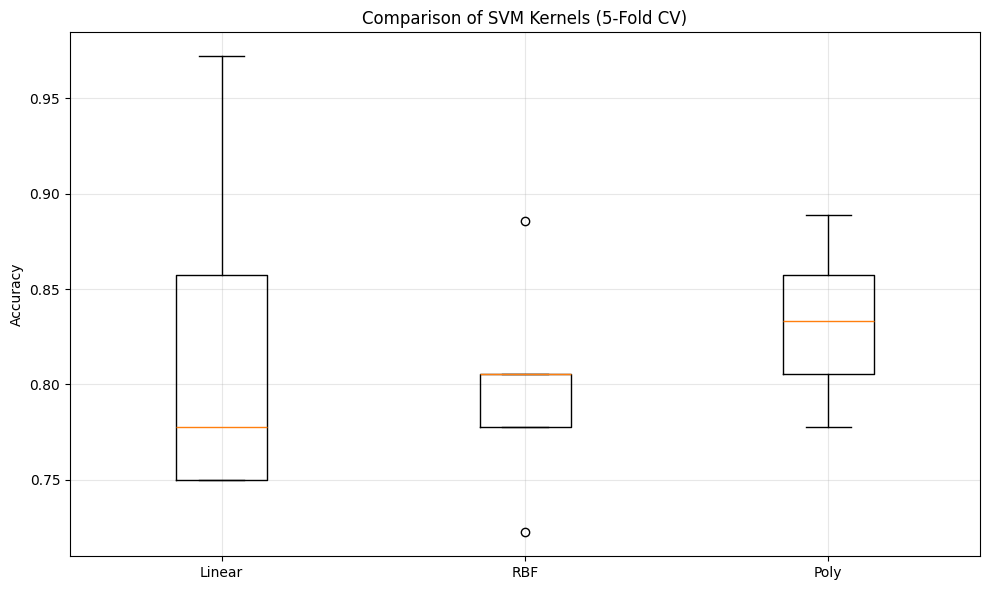

In [58]:
# Visualizar comparación
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot([results['Linear'], results['RBF'], results['Poly']],
            labels=['Linear', 'RBF', 'Poly'])
plt.ylabel('Accuracy')
plt.title('Comparison of SVM Kernels (5-Fold CV)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Comparación resultados en kaggle
## Regresión logística:
Liblinear: 0.70095
# SVM:
RBF: 0.76315
POLY: 0.77751
LINEAR: 0.76555

# ¿Qué modelo obtiene mejor rendimiento? ¿Por qué crees que es así?
### Claramente el modelo SVM da mucho mejor resultados
Los datos del titanic no guardan una relación lineal entre ellos, por lo que determina el resultado de supervivencia o no se basa sobretodo en relaciones complejas entre los datos.
# ¿Qué kernel de SVM funciona mejor y por qué?
### El kernel que mejores resultados ha dado ha sido "Poly" y es debido a que es capaz de capturar interacciones de orden superior (a diferencia del Linear) y es mucho más controlable que RBF (el cual con este dataset tan pequeño no es óptimo)

# ¿Qué insights interesantes descubriste sobre los supervivientes del Titanic?
### Sex:
Es claramente el atributo más determinante, habíendo una diferencia tremenda entre los supervivientes según su género (con casi un 70% de los supervivientes siendo mujeres).

### Class:
Es una categoría en la que hay gran diferencia entre las distintas clases y que, pese a esa gran diferencia, la clase con más supervivientes es la primera clase, representando casi el casi el 40% siendo apenas un 24% del total de los pasajeros (dataset de train)

Entre género y clase, se btiene que un 96.81% de las mujeres de primera clase consiguieron sobrevivir, siendo un grandisimo dato a tener en cuenta a la hora de tratar de predecir resultados

### Age:
Entre la edad de los 16 y los 40 años se representa la gran mayoría de los supervivientes, siendo una posible razón (solo fijandose en la edad) que las mujeres se encuentran en una edad fértil y los hombres en perfectas condiciones para trabajar/ir a la guerra.
También entran en juego los niños (menores de 16), que pese a ser un porcentaje mucho más bajo (un 9.3%) mas de la mitad de ellos (aproximadamente un 60%) sobrevivieron.

### Embarked:
No muy por detrás del género, el atributo embarked tiene una gran diferenciación entre sus 3 posibilidades, siendo la categoría S la que acapara aproximadamente un 64% de los supervivientes. Sin embargo, este atributo también tiene la mayoría del porcentaje en cuanto a muertos, por lo que indica que había una cantidad mucho mayor de esta categoría.

## Complejidad de los atributos:
En este caso no se pueden tratar por separados los atributos ya que no tienen una relación directa con los resultados por si solos. Hay que mirar los datos en combinaciones entre ellos para acabar encontrando aquellos que son más relevantes, no por si solos, sino junto a otros quetienen tambien mucha importancia (en este caso: género, clase y edad)